<a href="https://colab.research.google.com/github/hdemma/hdemma.github.io/blob/master/Micro_Prediction_Models/DieselBusModel/DieselBus_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

In [0]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)

scipy: 1.4.1
numpy: 1.18.1
matplotlib: 3.2.1
pandas: 1.0.3
statsmodels: 0.11.1
sklearn: 0.22.1
theano: 1.0.4


/Users/eason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/eason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/eason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/eason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

tensorflow: 1.13.1
keras: 2.3.1


Using TensorFlow backend.


In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import math
from matplotlib import pyplot

# Read Data

In [0]:
df = pd.read_excel('Gillig139_2020-01-01-0000_2020-02-01-0000.xlsm', index_col=False)
print(len(df))
df.columns

1048575


Index(['Unix Timestamp [ms]', 'Time [US/Eastern]',
       'Analysis - fuel - Fuel used [gal]',
       'Analysis - fuel - Fuel used driving [gal]',
       'Analysis - fuel - Fuel used idling [gal]',
       'Vehicle - Acceleratorpedal Position [%]',
       'Vehicle - Ambient Air Temperature [¬∞F]',
       'Engine - Engine Fuel Rate [gal/h]', 'Engine - Engine Speed [rpm]',
       'Vehicle - Wheel Based Vehicle Speed [mi/h]', 'GPS - Altitude [m]',
       'GPS - GPS position Latitude', 'GPS - GPS position Longitude',
       'GPS - GPS speed [mi/h]'],
      dtype='object')

# Linear Intrepolate Empty Entries

In [0]:
df.columns =['Timestamp', 'Time', 'FuelUsed', 'FuelDriving', 'FuelIdling', 'AccP', 'Temp', 'FuelRate', 'RPM', 'Speed',
            'Alt', 'Lat', 'Long', 'SpeedGPS']
AccP = df['AccP']
#print(AccP)
AccP = AccP.interpolate()
#print(AccP)
df['AccP']=AccP

FuelRate = df['FuelRate']
#print(FuelRate)
FuelRate = FuelRate.interpolate()
#print(FuelRate)
df['FuelRate'] = FuelRate

RPM = df['RPM']
#print(RPM)
RPM = RPM.interpolate()
#print(RPM)
df['RPM'] = RPM

Speed = df['Speed']
#print(Speed)
Speed = Speed.interpolate()
#print(Speed)
df['Speed'] = Speed

df1 = df[['AccP', 'FuelRate', 'RPM', 'Speed']]
print(len(df1))
df1=df1.dropna()
print(len(df1))
print(df1.head(3))

1048575
1046576
          AccP  FuelRate       RPM     Speed
1999  0.005458    1.9680  1000.325  0.000485
2000  0.008188    1.9745  1000.225  0.000969
2001  0.010917    1.9810  1000.125  0.001454


# Split Train and Test Datasets

In [0]:
df1['Speed2'] = df1['Speed']**2
df1['Speed3'] = df1['Speed']**3

train = df1.sample(n=math.floor(0.8*df1.shape[0]))
test = df1.sample(n=math.ceil(0.2*df1.shape[0]))

# Establish ANN model and train

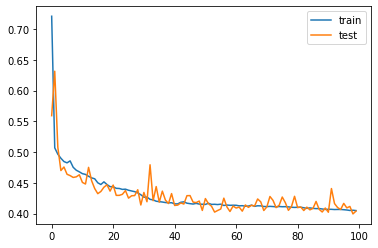

In [0]:
Y_train = train['FuelRate']
X_train = train[['AccP','Speed','RPM','Speed2','Speed3']]

Y_test = test['FuelRate']
X_test = test[['AccP','Speed','RPM','Speed2','Speed3']]

model = Sequential()
model.add(Dense(10,kernel_initializer='normal', input_dim=5, activation ='relu'))
model.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam')

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=256, verbose = 0)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Make predictions and plot against ground truth

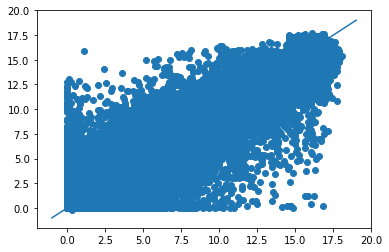

In [0]:
pre = model.predict(X_test)
abline_x = [-1, 19]
abline_y = [-1, 19]
pyplot.scatter(Y_test,pre)
pyplot.plot(abline_x,abline_y)
pyplot.show()

# Distributions of errors and ground truth values

In [0]:
difference = pre
for i in range(pre.shape[0]):
    difference[i] = Y_test.values[i] - pre[i]

In [0]:
dff = pd.DataFrame(data=difference, index=None, columns=None)

## Errors

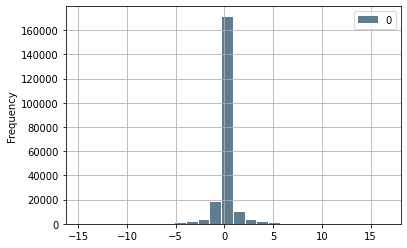

In [0]:
dff.plot.hist(grid=True, bins=26, rwidth=0.9,
                   color='#607c8e')

## Ground truth values

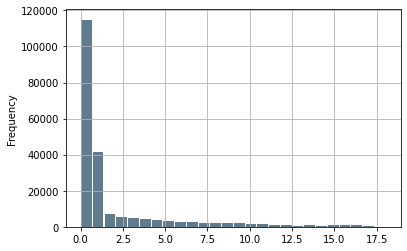

In [0]:
Y_test.plot.hist(grid=True, bins=26, rwidth=0.9,
                   color='#607c8e')